In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution2D,Reshape, Flatten, MaxPooling2D, Dropout, Lambda, BatchNormalization, LeakyReLU
from keras.layers.recurrent import LSTM
from keras.layers.embeddings import Embedding
from keras.callbacks import EarlyStopping, Callback
import time
import pickle
import gzip
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
%matplotlib inline

Using TensorFlow backend.


## load data ##

In [2]:
f = gzip.open('imdb.pkl.gz', 'rb')
train = pickle.load(f,encoding='latin1')
test = pickle.load(f,encoding='latin1')
f.close()

f = gzip.open('imdb.dict.pkl.gz', 'rb')
dic = pickle.load(f,encoding='latin1')
f.close()

In [3]:
def vec2sentence(ls):
    sen = ''
    for i in ls:
        for key in dic:
            if i == dic[key]:
                sen += key
                sen += ' '
                break
    return sen

In [4]:
vec2sentence(train[0][0])

'we really enjoyed grey owl : a simple tale well told in classic attenborough fashion : a little over-romanticized , with archetypes , humor , and a stress of dignity and values . &lt; br / &gt; &lt; br / &gt; beautifully shot and told at a nice pace this is the true story of archie , an englishman who turned native indian , and went to live and trap in canada . &lt; br / &gt; &lt; br / &gt; solid performances from all makes this film with a message easy viewing . &lt; br / &gt; &lt; br / &gt; two of the stars of the film are without a doubt the cutest we have ever seen - and the message is a good one with its ecoleanings . it must have been great to meet or read grey owl in the 1930s , a unique character and this is a fitting film tribute . '

In [5]:
train[1][0]

1

## clean data

In [6]:
wordsdata = []
for x in train[0]:
    wordsdata += x

### select the most 3000 frequent words and keep only review that has a length between 10 and 150 words

In [7]:
from collections import Counter
common_words = [i[0] for i in Counter(wordsdata).most_common(3000)]

In [8]:
def filter_list(full_list, excludes):
    s = set(excludes)
    return (x for x in full_list if x in s)

In [9]:
train_X = []
train_y = []
for i,X in enumerate(train[0]):
    X2 = list(filter_list(X, common_words))
    if len(X2) >= 10 and len(X2) <= 150:
        train_X.append(X2)
        train_y.append(train[1][i])

test_X = []
test_y = []
for i,X in enumerate(test[0]):
    X2 = list(filter_list(X, common_words))
    if len(X2) >= 10 and len(X2) <= 150:
        test_X.append(X2)
        test_y.append(test[1][i])

In [10]:
len(train_X), len(test_X)

(8233, 8435)

### padding 1 to the beginning and 0 to the end

In [11]:
maxlen = 151
for i in range(len(train_X)):
    train_X[i] = [1] + train_X[i]
    train_X[i] += [0] * (maxlen - len(train_X[i]))
    
for i in range(len(test_X)):
    test_X[i] = [1] + test_X[i]
    test_X[i] += [0] * (maxlen - len(test_X[i]))

In [12]:
train_X, train_y = shuffle(train_X, train_y)

## build model ##

In [37]:
model = Sequential()
model.add(Embedding(3002, 30, input_length=maxlen))
model.add(LSTM(30))
model.add(Dense(10))
model.add(Dense(1,activation='sigmoid'))

In [38]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_6 (Embedding)          (None, 151, 30)       90060       embedding_input_6[0][0]          
____________________________________________________________________________________________________
lstm_6 (LSTM)                    (None, 30)            7320        embedding_6[0][0]                
____________________________________________________________________________________________________
dense_11 (Dense)                 (None, 10)            310         lstm_6[0][0]                     
____________________________________________________________________________________________________
dense_12 (Dense)                 (None, 1)             11          dense_11[0][0]                   
Total params: 97,701
Trainable params: 97,701
Non-trainable params: 0
_____________________

In [39]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [40]:
history = model.fit(train_X, train_y, validation_data=(test_X,test_y),batch_size=100, nb_epoch=10)

Train on 8233 samples, validate on 8435 samples
Epoch 1/10
8233/8233 [==============================] - 25s - loss: 0.6219 - acc: 0.6470 - val_loss: 0.5175 - val_acc: 0.7876

validatiaon acc = 0.8545346713023703


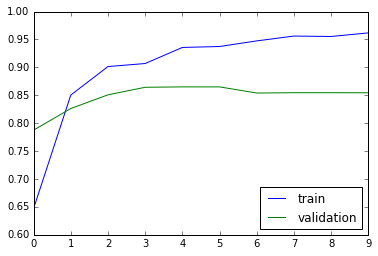

In [41]:
acc_train = history.history['acc']
acc_val = history.history['val_acc']
print('validatiaon acc = {}'.format(acc_val[-1]))
plt.plot(acc_train,label = 'train')
plt.plot(acc_val,label='validation')
plt.legend(loc=4)

In [42]:
test_loss, test_acc = model.evaluate(test_X, test_y, verbose=0,batch_size=128)

In [43]:
print(test_acc)

0.854534676553
